
🔧 Testing with 1 worker(s)...

⏱ Measuring Train loader (5 batches)...
[Train] Batch 1: 1.7873 sec
[Train] Batch 2: 2.5289 sec
[Train] Batch 3: 2.1261 sec
[Train] Batch 4: 2.1383 sec
[Train] Batch 5: 2.1206 sec

⏱ Measuring Val loader (5 batches)...
[Val] Batch 1: 1.9133 sec
[Val] Batch 2: 2.7471 sec
[Val] Batch 3: 2.1424 sec
[Val] Batch 4: 2.1228 sec
[Val] Batch 5: 2.0668 sec

⏱ Measuring Test loader (5 batches)...
[Test] Batch 1: 1.8543 sec
[Test] Batch 2: 2.6203 sec
[Test] Batch 3: 2.0697 sec
[Test] Batch 4: 2.0802 sec
[Test] Batch 5: 2.0603 sec

🔧 Testing with 2 worker(s)...

⏱ Measuring Train loader (5 batches)...
[Train] Batch 1: 2.2685 sec
[Train] Batch 2: 3.5779 sec
[Train] Batch 3: 3.3170 sec
[Train] Batch 4: 3.2615 sec
[Train] Batch 5: 3.2651 sec

⏱ Measuring Val loader (5 batches)...
[Val] Batch 1: 3.3511 sec
[Val] Batch 2: 3.8197 sec
[Val] Batch 3: 3.1975 sec
[Val] Batch 4: 3.2266 sec
[Val] Batch 5: 3.1550 sec

⏱ Measuring Test loader (5 batches)...
[Test] Batch 1: 3.2611 

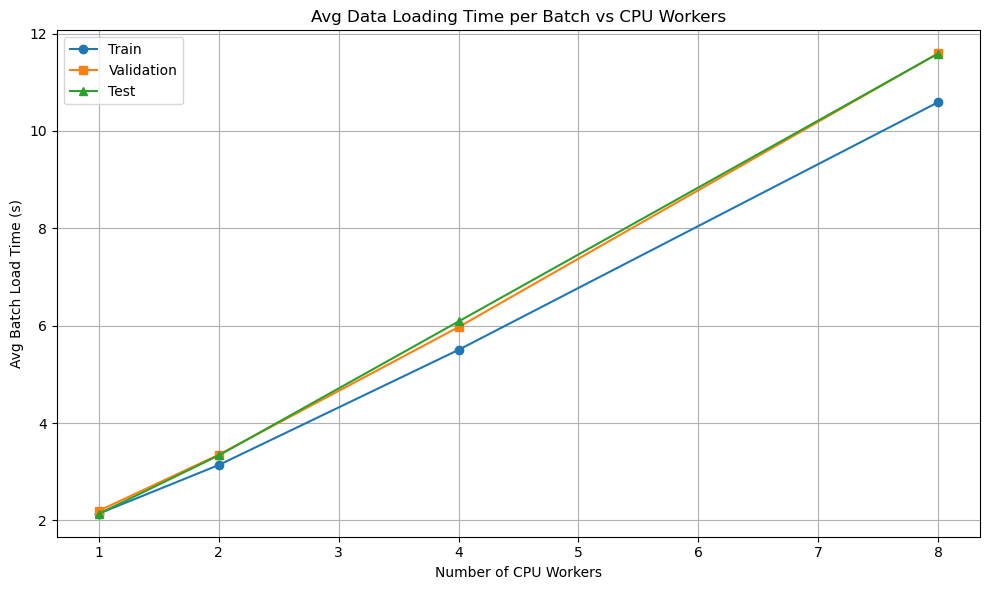

In [3]:
import os
import time
import torch
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torchvision import transforms
from transformers import ViTImageProcessor

# Constants
BATCH_SIZE = 64
IMG_SIZE = 224
WORKERS_LIST = [1, 2, 4, 8]
NUM_BATCHES_TO_MEASURE = 5

# Dataset paths
DATASET_DIR = "dataset"
CSV_PATH = os.path.join(DATASET_DIR, "train.csv")
IMAGE_DIR = os.path.join(DATASET_DIR, "train_data")

# Load and shuffle CSV
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()
df = df.drop(columns=['Unnamed: 0'], errors='ignore')
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

# Train/Val/Test Split
train_df = df.iloc[:60000].reset_index(drop=True)
val_df = df.iloc[60000:65000].reset_index(drop=True)
test_df = df.iloc[65000:70000].reset_index(drop=True)

# Preprocessing
image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

# Dataset Class
class ImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, os.path.basename(self.df.loc[idx, 'file_name']))
        image = Image.open(img_path).convert('RGB')
        label = int(self.df.loc[idx, 'label'])
        if self.transform:
            image = self.transform(image)
        return image, label

# Measure dataloader speed

def measure_dataloader_speed(loader, num_batches=20, label=""):
    print(f"\n⏱ Measuring {label} loader ({num_batches} batches)...")
    total_time = 0
    for i in range(num_batches):
        start = time.time()
        images, labels = next(iter(loader))
        batch_time = time.time() - start
        print(f"[{label}] Batch {i+1}: {batch_time:.4f} sec")
        total_time += batch_time
        if i + 1 >= num_batches:
            break
    return total_time / num_batches

# def measure_dataloader_speed(loader, num_batches=20, label=""):
#     print(f"\n⏱ Measuring {label} loader ({num_batches} batches)...")
#     total_time = 0
#     loader_iter = iter(loader)  # create persistent iterator ONCE
#     for i in range(num_batches):
#         start = time.time()
#         images, labels = next(loader_iter)
#         batch_time = time.time() - start
#         print(f"[{label}] Batch {i+1}: {batch_time:.4f} sec")
#         total_time += batch_time
#     return total_time / num_batches

# Test multiple worker settings
results = []
for workers in WORKERS_LIST:
    print(f"\n🔧 Testing with {workers} worker(s)...")

    train_ds = ImageDataset(train_df, IMAGE_DIR, transform)
    val_ds = ImageDataset(val_df, IMAGE_DIR, transform)
    test_ds = ImageDataset(test_df, IMAGE_DIR, transform)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,sampler=SequentialSampler(val_ds),
                              num_workers=workers, pin_memory=True, prefetch_factor=2,
                              persistent_workers=(workers > 0))
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, sampler=SequentialSampler(val_ds),
                            num_workers=workers, pin_memory=True, prefetch_factor=2,
                            persistent_workers=(workers > 0))
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, sampler=SequentialSampler(test_ds),
                             num_workers=workers, pin_memory=True, prefetch_factor=2,
                             persistent_workers=(workers > 0))

    train_time = measure_dataloader_speed(train_loader, NUM_BATCHES_TO_MEASURE, "Train")
    val_time = measure_dataloader_speed(val_loader, NUM_BATCHES_TO_MEASURE, "Val")
    test_time = measure_dataloader_speed(test_loader, NUM_BATCHES_TO_MEASURE, "Test")

    results.append({
        "CPU Workers": workers,
        "Train Load Time (s)": train_time,
        "Val Load Time (s)": val_time,
        "Test Load Time (s)": test_time
    })

# Show results
df_results = pd.DataFrame(results)
print("\n📊 Data Loading Benchmark Results:")
print(df_results)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df_results["CPU Workers"], df_results["Train Load Time (s)"], marker='o', label="Train")
plt.plot(df_results["CPU Workers"], df_results["Val Load Time (s)"], marker='s', label="Validation")
plt.plot(df_results["CPU Workers"], df_results["Test Load Time (s)"], marker='^', label="Test")
plt.title("Avg Data Loading Time per Batch vs CPU Workers")
plt.xlabel("Number of CPU Workers")
plt.ylabel("Avg Batch Load Time (s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Data Loading is Parallel
# Training is Serial